# Final Project by JF: Exploring the Restaurants in Toronto

In [1]:
from bs4 import BeautifulSoup
import requests

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import matplotlib.colors as colors
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

!conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud

import seaborn as sns
from scipy import stats

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.0.0               |             py_0         606 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

# 1. Data Preparation

In [2]:
# Obtain data from Wikipedia
source=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(source, 'lxml')

# Get table column names
table=soup.find('table', class_='wikitable sortable').find('tbody')
th=table.find('tr')
column_names=[]
for hd in th.find_all('th'):
    column_names.append(hd.text.rstrip())

Assign data into dataframe. Ignore cells with a borough that is **Not assigned**. If a cell has a borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough. 

In [3]:
neighborhoods=pd.DataFrame(columns=column_names)

for tr in table.find_all('tr'):
    data=[]
    for td in tr.find_all('td'):
        data.append(td.text.rstrip())
    if len(data)!=0:
        if data[1]!='Not assigned':
            if data[2]=='Not assigned':
                data[2]=data[1]
            neighborhoods=neighborhoods.append({column_names[0]: data[0], column_names[1]: data[1], column_names[2]: data[2]}, ignore_index=True)

print('The size of neighborhoods:', neighborhoods.shape)
neighborhoods.head()

The size of neighborhoods: (210, 3)


,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [4]:
# Create dataframe toronto_df in which the neighborhoods with the same postal code will be combined into one row with the neighborhoods separated with a comma. 

toronto_df=pd.DataFrame(columns=column_names)
unique_code=neighborhoods['Postcode'].unique()
for post in unique_code:
    neighbor=neighborhoods[neighborhoods['Postcode']==post]
    string=neighbor.iloc[0, 2]
    for i in range(neighbor.shape[0]-1):
        string=', '.join([string, neighbor.iloc[i+1, 2]])
    toronto_df=toronto_df.append({column_names[0]: neighbor.iloc[0,0], column_names[1]: neighbor.iloc[0,1], column_names[2]: string}, ignore_index=True)

print('The size of toronto_df:', toronto_df.shape)
toronto_df.head()

The size of toronto_df: (103, 3)


,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [5]:
# Get the latitude and the longitude coordinates of each neighborhood.
geo_coor=pd.read_csv('http://cocl.us/Geospatial_data')
geo_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
toronto_df=pd.merge(toronto_df, geo_coor, how='inner', left_on='Postcode', right_on='Postal Code')
toronto_df.head()

,Postcode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",M6A,43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,M7A,43.662301,-79.389494


In [7]:
toronto_df.drop('Postal Code', axis=1, inplace=True)
print('The size of toronto_df:', toronto_df.shape)
toronto_df.head()

The size of toronto_df: (103, 5)


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [8]:
# Explore the neighborhoods in Toronto. Work with only boroughs that contain the word Toronto.
toronto_df2=toronto_df.loc[toronto_df['Borough'].str.contains('toronto', case=False)].reset_index(drop=True)
print('The size of toronto_df2', toronto_df2.shape)
toronto_df2

The size of toronto_df2 (39, 5)


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M9A,Downtown Toronto,Queen's Park,43.667856,-79.532242
2,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
9,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259


In [9]:
# Create a map of Toronto with neighborhoods

# Obtain the geograpical coordinate of Toronto
address='Toronto, ON, Canada'
geolocator=Nominatim(user_agent="toronto_explorer")
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

#create map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df2['Latitude'], toronto_df2['Longitude'], toronto_df2['Borough'], toronto_df2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
        
map_toronto

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [10]:
# The code was removed by Watson Studio for sharing.

Foursquare Credentails (CLIENT_ID, CLIENT_SECRET) are defined.


In [11]:
VERSION = '20180605' 
LIMIT=100

In [12]:
# Define a function to get the top 100 venues that are in each Neighborhood within a radius of 500 meters

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# Create a new dataframe toronto_venues on each neighborhoods in toronto_df2
toronto_venues = getNearbyVenues(names=toronto_df2['Neighborhood'],
                                   latitudes=toronto_df2['Latitude'],
                                   longitudes=toronto_df2['Longitude']
                                  )

Harbourfront
Queen's Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

In [14]:
# Check the size of the resulting dataframe
print('The size of toronto_venues:', toronto_venues.shape)
toronto_venues.head()

The size of toronto_venues: (1670, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,54ea41ad498e9a11e9e13308,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,53b8466a498e83df908c3f21,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,574c229e498ebb5c6b257902,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,50760559e4b0e8c7babe2497,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Impact Kitchen,5612b1cc498e3dd742af0dc8,43.656369,-79.356980,Restaurant


In [15]:
# The number of venues returned for each neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56,56
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14,14
"Cabbagetown, St. James Town",45,45,45,45,45,45,45
Central Bay Street,84,84,84,84,84,84,84
"Chinatown, Grange Park, Kensington Market",90,90,90,90,90,90,90
Christie,17,17,17,17,17,17,17


In [16]:
# The number of unique categories from all the venues
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 232 unique categories.


# 2. Data Exploration
## 2.1 Total number of venues vs total number of restaurants in each neighborhood

In [17]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move Neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print('The size of toronto_onehot:', toronto_onehot.shape)
toronto_onehot.head()

The size of toronto_onehot: (1670, 232)


,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Harbourfront,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [18]:
# Group rows by neighborhood and sum the occurrence of each category
toronto_grouped_sum=toronto_onehot.groupby('Neighborhood').sum().reset_index()

# Sum all the categories for each neighborhood
toronto_grouped_sum['Total Venues']=toronto_grouped_sum.sum(axis=1)

# Sum all the categories that have "restaurant" in the name for each neighborhood
column_restaurant=toronto_grouped_sum.columns[[i for i in range(toronto_grouped_sum.shape[1]) if 'restaurant' in toronto_grouped_sum.columns[i].lower()]]
toronto_grouped_sum['Total Restaurants']=toronto_grouped_sum.loc[:, column_restaurant].sum(axis=1)

# Total_Restaurant/Total_Venues
toronto_grouped_sum['Percent Restaurant']=toronto_grouped_sum['Total Restaurants']/toronto_grouped_sum['Total Venues']

print('The size of toronto_grouped_sum:', toronto_grouped_sum.shape)
toronto_grouped_sum

The size of toronto_grouped_sum: (38, 235)


,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Total Venues,Total Restaurants,Percent Restaurant
0,"Adelaide, King, Richmond",0,0,0,0,0,0,0,2,0,0,1,0,3,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,3,1,0,0,5,0,0,0,0,0,0,0,0,0,1,0,8,0,0,0,1,0,0,2,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,1,0,2,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,0,0,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0,1,0,0,0,2,0,1,0,0,0,0,0,1,1,0,0,3,0,0,2,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,4,0,0,3,0,0,0,0,0,0,0,3,1,0,0,0,0,0,2,0,0,1,0,99,29,0.292929
1,Berczy Park,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,2,0,0,0,1,1,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,0,2,0,0,0,

In [19]:
print('The total number of restaurants:', toronto_grouped_sum.sum().reset_index().iloc[-2, 1])

The total number of restaurants: 398


In [20]:
toronto_grouped_sum[['Neighborhood', 'Total Venues', 'Total Restaurants', 'Percent Restaurant']]

,Neighborhood,Total Venues,Total Restaurants,Percent Restaurant
0,"Adelaide, King, Richmond",99,29,0.292929
1,Berczy Park,56,9,0.160714
2,"Brockton, Exhibition Place, Parkdale Village",22,2,0.090909
3,Business Reply Mail Processing Centre 969 Eastern,16,2,0.125000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",14,0,0.000000
5,"Cabbagetown, St. James Town",45,11,0.244444
6,Central Bay Street,84,22,0.261905
7,"Chinatown, Grange Park, Kensington Market",90,34,0.377778
8,Christie,17,2,0.117647
9,Church and Wellesley,83,27,0.325301


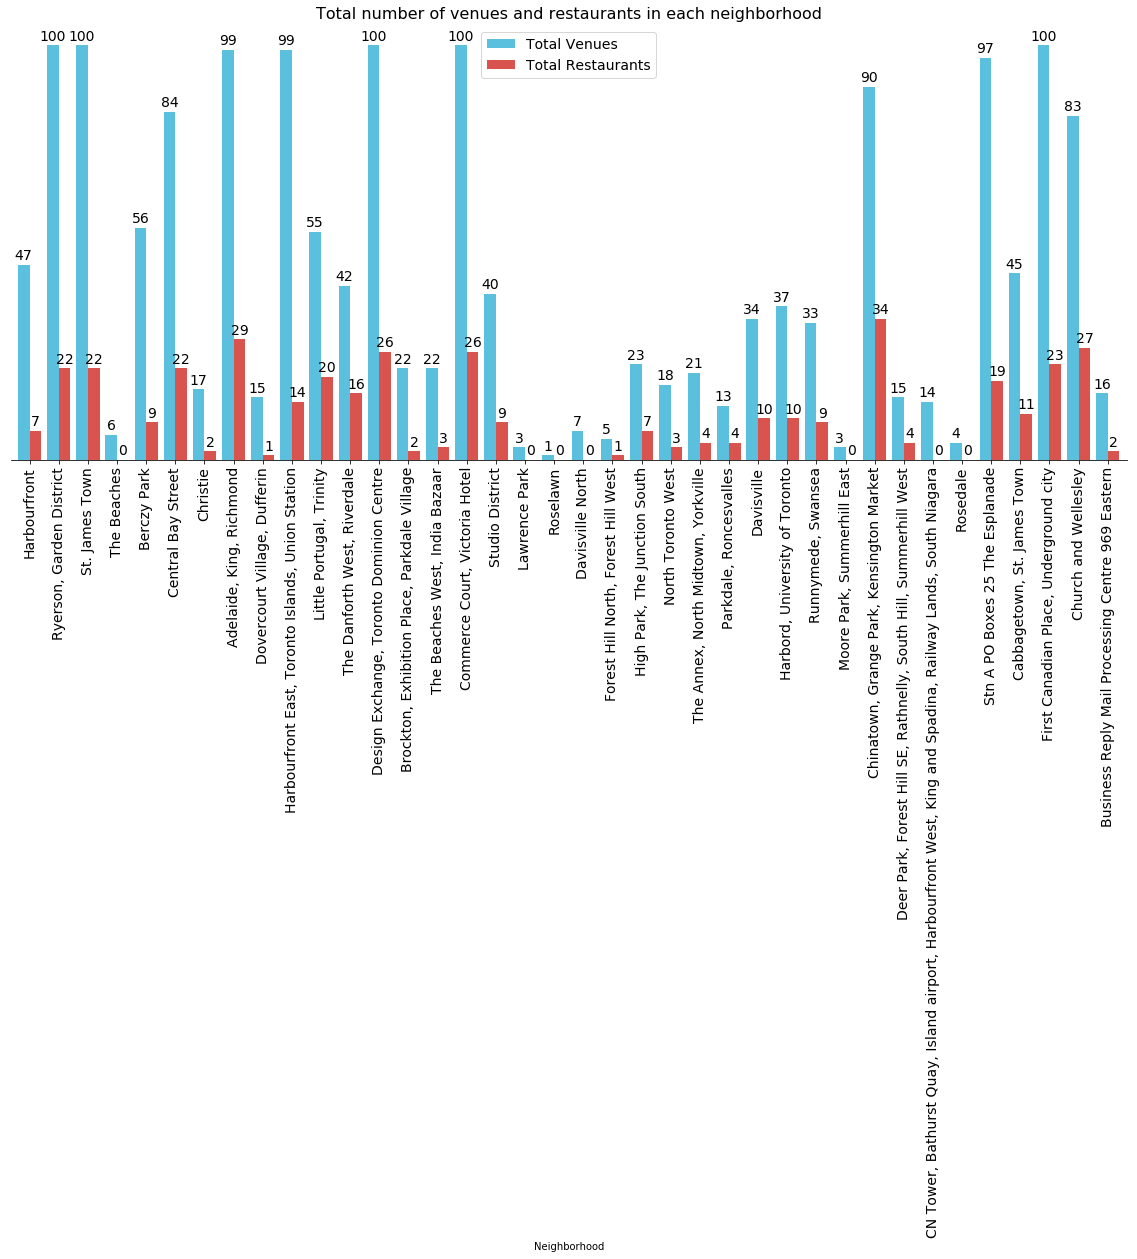

In [21]:
toronto_temp=pd.merge(toronto_df2, toronto_grouped_sum, how='inner', left_on='Neighborhood', right_on='Neighborhood')[['Neighborhood', 'Latitude', 'Longitude', 'Total Venues', 'Total Restaurants']]

toronto_temp2=toronto_temp[['Neighborhood', 'Total Venues', 'Total Restaurants']]
toronto_temp2.set_index('Neighborhood', inplace=True)

ax=toronto_temp2.plot(kind='bar', figsize=(20, 8),width=0.8, color=['#5bc0de', '#d9534f']) 

ax.tick_params(left=False, labelsize=14)
ax.axes.yaxis.set_ticklabels([])

ax.legend(fontsize=14)
ax.set_title('Total number of venues and restaurants in each neighborhood', fontsize=16)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(toronto_temp2)):
    for j in range(2):
        plt.annotate(str(toronto_temp2.iloc[i,j]), 
                     xy=(i+0.4*(j-0.5), toronto_temp2.iloc[i,j]+0.5),                  
                     va='bottom', 
                     ha='center',
                     size=14
                    )
        
plt.show()

Text(0.5, 1.0, 'Total Venues Bins')

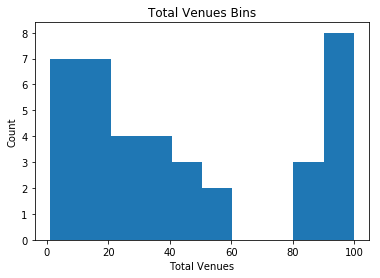

In [22]:
plt.hist(toronto_grouped_sum['Total Venues'])

# set x/y labels and plot title
plt.xlabel('Total Venues')
plt.ylabel('Count')
plt.title('Total Venues Bins')

Text(0.5, 1.0, 'Total Restaurants Bins')

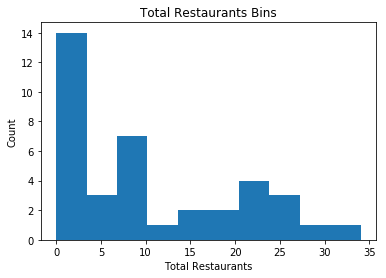

In [23]:
plt.hist(toronto_grouped_sum['Total Restaurants'])

# set x/y labels and plot title
plt.xlabel('Total Restaurants')
plt.ylabel('Count')
plt.title('Total Restaurants Bins')

In [24]:
# Create map of Toronto using latitude and longitude values, color represents the number of venues
map_toronto_ven = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the total number of restaurants
minimum=toronto_temp['Total Venues'].min()
maximum=toronto_temp['Total Venues'].max()

# add markers to map
markers_colors = []
for lat, lng, label, num in zip(toronto_temp['Latitude'], toronto_temp['Longitude'], toronto_temp['Neighborhood'], toronto_temp['Total Venues']):
    label = folium.Popup(label+'. Total number of venues: '+str(num), parse_html=True)
    ratio = 2 * (num-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#{:02X}{:02X}{:02X}'.format(r,g,b),
        fill=True,
        fill_color='#{:02X}{:02X}{:02X}'.format(r,g,b),
        fill_opacity=0.7).add_to(map_toronto_ven)  
    
map_toronto_ven


In [25]:
# Create map of Toronto using latitude and longitude values, color represents the number of restaurants
map_toronto_res = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the total number of restaurants
minimum=toronto_temp['Total Restaurants'].min()
maximum=toronto_temp['Total Restaurants'].max()

# add markers to map
markers_colors = []
for lat, lng, label, num in zip(toronto_temp['Latitude'], toronto_temp['Longitude'], toronto_temp['Neighborhood'], toronto_temp['Total Restaurants']):
    label = folium.Popup(label+'. Total number of restaurants: '+str(num), parse_html=True)
    ratio = 2 * (num-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#{:02X}{:02X}{:02X}'.format(r,g,b),
        fill=True,
        fill_color='#{:02X}{:02X}{:02X}'.format(r,g,b),
        fill_opacity=0.7).add_to(map_toronto_res)  
    
map_toronto_res


In [26]:
toronto_grouped_sum[['Neighborhood', 'Total Venues']].sort_values(by='Total Venues', ascending=False).head(10)

,Neighborhood,Total Venues
14,"Design Exchange, Toronto Dominion Centre",100
31,St. James Town,100
30,"Ryerson, Garden District",100
10,"Commerce Court, Victoria Hotel",100
16,"First Canadian Place, Underground city",100
0,"Adelaide, King, Richmond",99
20,"Harbourfront East, Toronto Islands, Union Station",99
32,Stn A PO Boxes 25 The Esplanade,97
7,"Chinatown, Grange Park, Kensington Market",90
6,Central Bay Street,84


In [27]:
toronto_grouped_sum[['Neighborhood', 'Total Restaurants']].sort_values(by='Total Restaurants', ascending=False).head(10)

,Neighborhood,Total Restaurants
7,"Chinatown, Grange Park, Kensington Market",34
0,"Adelaide, King, Richmond",29
9,Church and Wellesley,27
14,"Design Exchange, Toronto Dominion Centre",26
10,"Commerce Court, Victoria Hotel",26
16,"First Canadian Place, Underground city",23
31,St. James Town,22
30,"Ryerson, Garden District",22
6,Central Bay Street,22
23,"Little Portugal, Trinity",20


Text(0, 0.5, 'Total number of restaurants')

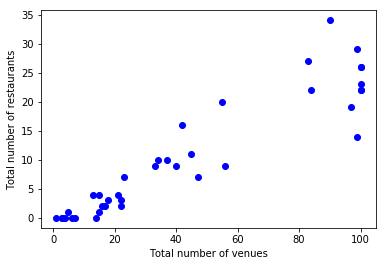

In [28]:
plt.scatter(toronto_grouped_sum['Total Venues'], toronto_grouped_sum['Total Restaurants'], color='blue')
plt.xlabel('Total number of venues')
plt.ylabel('Total number of restaurants')

Text(0, 0.5, 'Ratio of total number of restaurants to total number of venues')

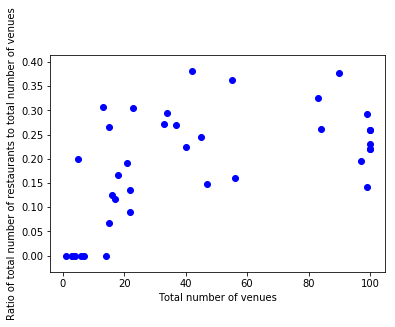

In [29]:
plt.scatter(toronto_grouped_sum['Total Venues'], toronto_grouped_sum['Percent Restaurant'], color='blue')
plt.xlabel('Total number of venues')
plt.ylabel('Ratio of total number of restaurants to total number of venues')

Text(0, 0.5, 'Ratio of total number of restaurants to total number of venues')

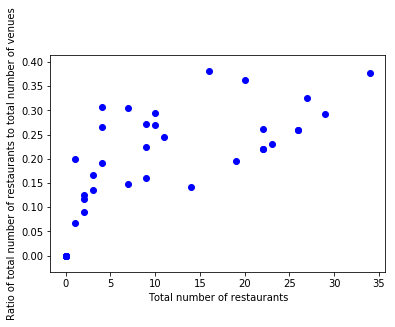

In [30]:
plt.scatter(toronto_grouped_sum['Total Restaurants'], toronto_grouped_sum['Percent Restaurant'], color='blue')
plt.xlabel('Total number of restaurants')
plt.ylabel('Ratio of total number of restaurants to total number of venues')

In [31]:
# Calculate correlation between 'Total Venues' and 'Total Restaurants', as well as between 'Total Venues' and 'Percent Restaurant'
toronto_grouped_sum[['Total Venues', 'Total Restaurants', 'Percent Restaurant']].corr()

,Total Venues,Total Restaurants,Percent Restaurant
Total Venues,1.000000,0.929100,0.544942
Total Restaurants,0.929100,1.000000,0.708037
Percent Restaurant,0.544942,0.708037,1.000000


In [32]:
# Remove the neighborhoods that the number of venues reaches the search limit 100, and recalculate the correlation
temp=toronto_grouped_sum[toronto_grouped_sum['Total Venues']<100][['Total Venues', 'Total Restaurants', 'Percent Restaurant']]
temp.corr()

,Total Venues,Total Restaurants,Percent Restaurant
Total Venues,1.000000,0.907626,0.564633
Total Restaurants,0.907626,1.000000,0.733205
Percent Restaurant,0.564633,0.733205,1.000000


(0, 35.92233398587398)

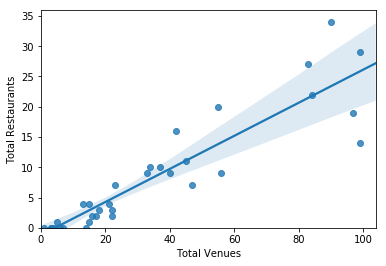

In [33]:
sns.regplot(x='Total Venues', y='Total Restaurants', data=temp)
plt.xlim(0,)
plt.ylim(0,)

(0, 0.4857835950201276)

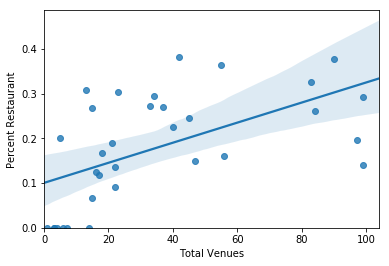

In [34]:
sns.regplot(x='Total Venues', y='Percent Restaurant', data=temp)
plt.xlim(0,)
plt.ylim(0,)

(0, 0.5988433359578277)

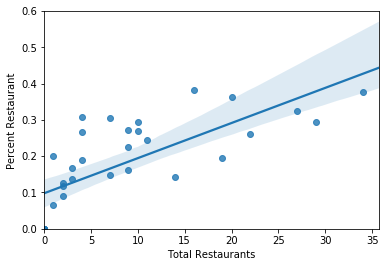

In [35]:
sns.regplot(x='Total Restaurants', y='Percent Restaurant', data=temp)
plt.xlim(0,)
plt.ylim(0,)

In [36]:
pearson_coef, p_value=stats.pearsonr(temp['Total Venues'], temp['Total Restaurants'])
print('The Pearson Correlation coefficient is', pearson_coef, 'with a P-value of P=', p_value)

The Pearson Correlation coefficient is 0.9076259251684811 with a P-value of P= 3.2044107425356134e-13


In [37]:
pearson_coef, p_value=stats.pearsonr(temp['Total Venues'], temp['Percent Restaurant'])
print('The Pearson Correlation coefficient is', pearson_coef, 'with a P-value of P=', p_value)

The Pearson Correlation coefficient is 0.5646327039124981 with a P-value of P= 0.0006192904492225316


In [38]:
pearson_coef, p_value=stats.pearsonr(temp['Total Restaurants'], temp['Percent Restaurant'])
print('The Pearson Correlation coefficient is', pearson_coef, 'with a P-value of P=', p_value)

The Pearson Correlation coefficient is 0.7332053046882615 with a P-value of P= 1.215494315029635e-06


In [39]:
lm=LinearRegression()
lm.fit(temp[['Total Venues']], temp[['Total Restaurants']])
print('The intercept is', lm.intercept_[0], 'and the slope is', lm.coef_[0][0])

The intercept is -1.194564146280424 and the slope is 0.27308800757054374


In [40]:
lm.score(temp[['Total Venues']], temp[['Total Restaurants']])

0.8237848200379414

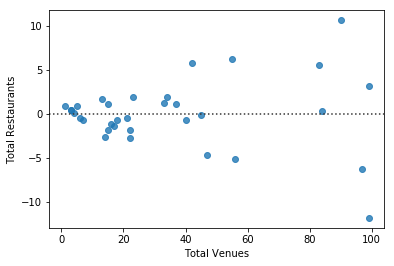

In [41]:
# Residual plot: if randomly spread out around the x-axis, then a linear model is appropriate for the data
sns.residplot(temp['Total Venues'], temp['Total Restaurants'])

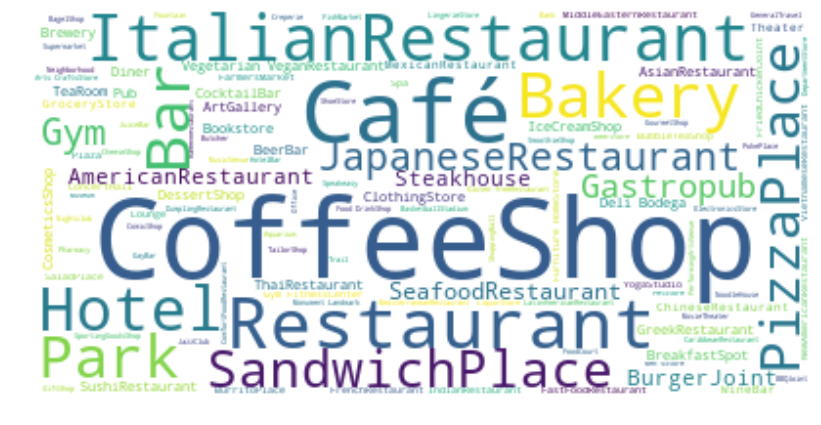

In [42]:
# Create Word Clouds for 'Venue Category' in Toronto

word_string = ''
for category in toronto_venues['Venue Category'].values:
    # check if the category has more than one words
    if len(category.split(' '))>1:
        category=category.replace(' ', '')
        
    word_string = word_string + (category + ' ') 

# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 2.2 Frequency of occurrence of each category in each neighborhood

In [43]:
# Group rows by neighborhood and take the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

print('The size of toronto_grouped:', toronto_grouped.shape)
toronto_grouped.head()

The size of toronto_grouped: (38, 232)


,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,0.010000,0.0,0.03,0.0,0.0000,0.000000,0.0,0.000000,0.020000,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.01,0.000000,0.01,0.010000,0.0000,0.0,0.01,0.03,0.010000,0.0,0.000000,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.010000,0.000000,0.080000,0.0,0.0,0.0,0.01,0.000000,0.0000,0.020000,0.000000,0.02,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0000,0.02,0.0,0.0,0.01

In [44]:
# Print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.08
1              Café  0.05
2        Steakhouse  0.04
3               Bar  0.04
4  Sushi Restaurant  0.03


----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.05
2   Cheese Shop  0.04
3    Steakhouse  0.04
4        Bakery  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0            Café  0.14
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3     Yoga Studio  0.05
4    Intersection  0.05


----Business Reply Mail Processing Centre 969 Eastern----
              venue  freq
0       Yoga Studio  0.06
1  Recording Studio  0.06
2        Skate Park  0.06
3    Farmers Market  0.06
4               Spa  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
                venue  freq
0     Airport Service  0.21
1    Airport Terminal  0.14
2            Boutique  0.07
3            

In [45]:
# Define a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
# Create the new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

print('The size of neighborhoods_venues_sorted:', neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

The size of neighborhoods_venues_sorted: (38, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Burger Joint,Restaurant,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Salad Place
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Cheese Shop,Bakery,Steakhouse,Seafood Restaurant,Café,Beer Bar,Park
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Yoga Studio,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Garden,Burrito Place,Fast Food Restaurant,Auto Workshop,Farmers Market,Spa,Restaurant,Recording Studio,Garden Center
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Boat or Ferry,Harbor / Marina,Airport,Airport Food Court,Airport Lounge,Boutique,Sculpture Garden,Bar


In [47]:
# The 10 most common venues in the top 10 neighborhoods that sorted by the total number of venues
neighborhoodTop10=toronto_grouped_sum[['Neighborhood', 'Total Venues']].sort_values(by='Total Venues', ascending=False).iloc[0:10, 0].tolist()
neighborhoods_venues_sorted10=pd.DataFrame(columns=columns)

for j in range(10):
    for i in range(len(neighborhoods_venues_sorted)):
        if neighborhoods_venues_sorted.iloc[i,0]==neighborhoodTop10[j]:
            neighborhoods_venues_sorted10=neighborhoods_venues_sorted10.append(neighborhoods_venues_sorted.iloc[i, :])
neighborhoods_venues_sorted10

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Hotel,Café,Italian Restaurant,Restaurant,American Restaurant,Bar,Bakery,Deli / Bodega,Gastropub
31,St. James Town,Café,Coffee Shop,Restaurant,Hotel,Breakfast Spot,Cocktail Bar,Beer Bar,Cosmetics Shop,Bakery,Diner
30,"Ryerson, Garden District",Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Pizza Place,Fast Food Restaurant,Plaza,Bookstore,Sporting Goods Shop
10,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,American Restaurant,Steakhouse,Gym,Seafood Restaurant,Deli / Bodega
16,"First Canadian Place, Underground city",Coffee Shop,Café,Hotel,Restaurant,Gym,Steakhouse,Burger Joint,Seafood Restaurant,Deli / Bodega,Asian Restaurant
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Burger Joint,Restaurant,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Salad Place
20,"Harbourfront East, Toronto Islands, Union Station",Coffee Shop,Aquarium,Hotel,Italian Restaurant,Café,Scenic Lookout,Brewery,Fried Chicken Joint,Restaurant,History Museum
32,Stn A PO Boxes 25 The Esplanade,Coffee Shop,Restaurant,Café,Japanese Restaurant,Seafood Restaurant,Hotel,Beer Bar,Cocktail Bar,Sandwich Place,Breakfast Spot
7,"Chinatown, Grange Park, Kensington Market",Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Café,Bar,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Cocktail Bar
6,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Ice Cream Shop,Burger Joint,Middle Eastern Restaurant,Juice Bar,Japanese Restaurant,Salad Place


In [48]:
# The 10 most common venues of the top 10 neighborhoods that sorted by the total number of restaurants
neighborhoodTop10=toronto_grouped_sum[['Neighborhood', 'Total Restaurants']].sort_values(by='Total Restaurants', ascending=False).iloc[0:10, 0].tolist()
neighborhoods_venues_sorted10=pd.DataFrame(columns=columns)

for j in range(10):
    for i in range(len(neighborhoods_venues_sorted)):
        if neighborhoods_venues_sorted.iloc[i,0]==neighborhoodTop10[j]:
            neighborhoods_venues_sorted10=neighborhoods_venues_sorted10.append(neighborhoods_venues_sorted.iloc[i, :])
neighborhoods_venues_sorted10

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"Chinatown, Grange Park, Kensington Market",Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Café,Bar,Coffee Shop,Dumpling Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Cocktail Bar
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Burger Joint,Restaurant,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Salad Place
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Mediterranean Restaurant,Gym,Hotel,Gastropub,Café
14,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Hotel,Café,Italian Restaurant,Restaurant,American Restaurant,Bar,Bakery,Deli / Bodega,Gastropub
10,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,American Restaurant,Steakhouse,Gym,Seafood Restaurant,Deli / Bodega
16,"First Canadian Place, Underground city",Coffee Shop,Café,Hotel,Restaurant,Gym,Steakhouse,Burger Joint,Seafood Restaurant,Deli / Bodega,Asian Restaurant
31,St. James Town,Café,Coffee Shop,Restaurant,Hotel,Breakfast Spot,Cocktail Bar,Beer Bar,Cosmetics Shop,Bakery,Diner
30,"Ryerson, Garden District",Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Pizza Place,Fast Food Restaurant,Plaza,Bookstore,Sporting Goods Shop
6,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Ice Cream Shop,Burger Joint,Middle Eastern Restaurant,Juice Bar,Japanese Restaurant,Salad Place
23,"Little Portugal, Trinity",Bar,Asian Restaurant,Restaurant,Pizza Place,Men's Store,New American Restaurant,Coffee Shop,Café,Vegetarian / Vegan Restaurant,Vietnamese Restaurant


In [49]:
# Sum all the categories that have "restaurant" in the name for each neighborhood
column_restaurant=toronto_grouped.columns[[i for i in range(toronto_grouped.shape[1]) if 'restaurant' in toronto_grouped.columns[i].lower()]]
toronto_grouped['Frequency_Restaurant']=toronto_grouped.loc[:, column_restaurant].sum(axis=1)

print('The size of toronto_grouped:', toronto_grouped.shape)
toronto_grouped.head()

The size of toronto_grouped: (38, 233)


,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Frequency_Restaurant
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,0.010000,0.0,0.03,0.0,0.0000,0.000000,0.0,0.000000,0.020000,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.01,0.000000,0.01,0.010000,0.0000,0.0,0.01,0.03,0.010000,0.0,0.000000,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.010000,0.000000,0.080000,0.0,0.0,0.0,0.01,0.000000,0.0000,0.020000,0.000000,0.02,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0

In [50]:
# Sort Descending
toronto_grouped.sort_values(by='Frequency_Restaurant', ascending=False)

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Frequency_Restaurant
37,"The Danforth West, Riverdale",0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.023810,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.00,0.000000,0.023810,0.023810,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.023810,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,

## 2.3 Restaurants in the neighborhood

In [51]:
# Create dataframe toronto_restaurants with only venues categorized as restaurant
toronto_restaurants = toronto_venues.loc[(toronto_venues['Venue Category'].str.contains('restaurant', case=False))].reset_index(drop=True)
print('The total number of restaurants:', len(toronto_restaurants))
toronto_restaurants.head()

The total number of restaurants: 398


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Impact Kitchen,5612b1cc498e3dd742af0dc8,43.656369,-79.356980,Restaurant
1,Harbourfront,43.65426,-79.360636,Cluny Bistro & Boulangerie,53a22c92498ec91fda7ce133,43.650565,-79.357843,French Restaurant
2,Harbourfront,43.65426,-79.360636,El Catrin,51ddecee498e1ffd34185d2f,43.650601,-79.358920,Mexican Restaurant
3,Harbourfront,43.65426,-79.360636,Cocina Economica,5542ab36498e2f92a8c248f2,43.654959,-79.365657,Mexican Restaurant
4,Harbourfront,43.65426,-79.360636,Izumi,50e88fc6e4b007fcbb57aae8,43.649970,-79.360153,Asian Restaurant


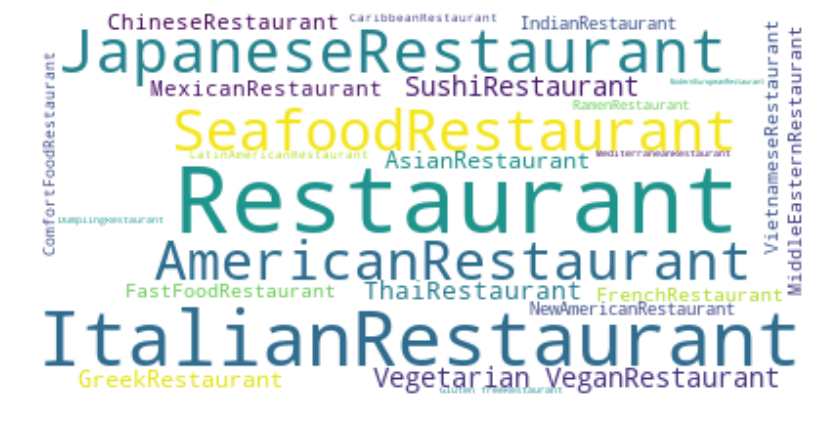

In [52]:
# Create Word Clouds for 'Venue Category' in toronto_restaurants

word_string = ''
for category in toronto_restaurants['Venue Category'].values:
    # check if the category has more than one words
    if len(category.split(' '))>1:
        category=category.replace(' ', '')
        
    word_string = word_string + (category + ' ') 

# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [53]:
toronto_restaurants['Venue Category'].value_counts()

Restaurant                         53
Italian Restaurant                 44
Japanese Restaurant                26
Seafood Restaurant                 23
American Restaurant                21
Vegetarian / Vegan Restaurant      21
Sushi Restaurant                   20
Thai Restaurant                    18
Greek Restaurant                   15
Asian Restaurant                   14
Chinese Restaurant                 12
Mexican Restaurant                 11
French Restaurant                  10
Vietnamese Restaurant              10
Middle Eastern Restaurant           9
Fast Food Restaurant                9
New American Restaurant             8
Indian Restaurant                   8
Comfort Food Restaurant             7
Ramen Restaurant                    6
Latin American Restaurant           5
Caribbean Restaurant                5
Dumpling Restaurant                 4
Mediterranean Restaurant            4
Gluten-free Restaurant              4
Modern European Restaurant          3
Falafel Rest

In [54]:
# Add the detail info of the restaurant into the dataframe
for i, venue_id in enumerate(toronto_restaurants['Venue ID']):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    results = requests.get(url).json()["response"]['venue']
    
    # Price tier: 1-Cheap, 2-Moderate, 3-Expensive, 4-Very Expensive
    try:
        toronto_restaurants.loc[i, 'Price']=results['price']['tier']
    except:
        toronto_restaurants.loc[i, 'Price']=np.nan
    try:
        toronto_restaurants.loc[i, 'Rating']=results['rating']
    except:
        toronto_restaurants.loc[i, 'Rating']=np.nan
        
    toronto_restaurants.loc[i, 'Likes']=results['likes']['count']
    toronto_restaurants.loc[i, 'OK']=results['ok']
    toronto_restaurants.loc[i, 'Dislike']=results['dislike']


In [55]:
print('The size of toronto_restaurants:', toronto_restaurants.shape)
toronto_restaurants

The size of toronto_restaurants: (398, 13)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Price,Rating,Likes,OK,Dislike
0,Harbourfront,43.654260,-79.360636,Impact Kitchen,5612b1cc498e3dd742af0dc8,43.656369,-79.356980,Restaurant,2.0,8.8,51.0,False,False
1,Harbourfront,43.654260,-79.360636,Cluny Bistro & Boulangerie,53a22c92498ec91fda7ce133,43.650565,-79.357843,French Restaurant,4.0,8.4,183.0,False,False
2,Harbourfront,43.654260,-79.360636,El Catrin,51ddecee498e1ffd34185d2f,43.650601,-79.358920,Mexican Restaurant,3.0,8.1,465.0,False,False
3,Harbourfront,43.654260,-79.360636,Cocina Economica,5542ab36498e2f92a8c248f2,43.654959,-79.365657,Mexican Restaurant,1.0,7.9,67.0,False,False
4,Harbourfront,43.654260,-79.360636,Izumi,50e88fc6e4b007fcbb57aae8,43.649970,-79.360153,Asian Restaurant,2.0,8.0,18.0,False,False
5,Harbourfront,43.654260,-79.360636,Archeo,4ac3e6cef964a520629d20e3,43.650667,-79.359431,Italian Restaurant,2.0,7.4,20.0,False,False
6,Harbourfront,43.654260,-79.360636,Flame Shack,51c085d3498eadedb67ba6cd,43.656844,-79.358917,Restaurant,2.0,NaN,5.0,False,False
7,"Ryerson, Garden District",43.657162,-79.378937,Hokkaido Ramen Santouka らーめん山頭火,509e9ef6e4b0ab175389a6c5,43.656435,-79.377586,Ramen Restaurant,2.0,8.3,306.0,False,False
8,"Ryerson, Garden District",43.657162,-79.378937,Salad King,4ad4c061f964a52095f720e3,43.657601,-79.381620,Thai Restaurant,2.0,8.2,490.0,False,False
9,"Ryerson, Garden District",43.657162,-79.378937,JOEY Eaton Centre,59246b5aad1789316b35d66c,43.655404,-79.381929,Restaurant,2.0,8.4,9.0,False,False


In [56]:
# Check the values of column 'OK'
toronto_restaurants['OK'].unique()

array([False])

In [57]:
# Check the values of column 'Dislike'
toronto_restaurants['Dislike'].unique()

array([False])

In [58]:
# Since both columns 'OK' and 'Dislike' do not have any useful data in it, these two columns are removed. 
toronto_restaurants.drop(['OK', 'Dislike'], axis=1, inplace=True)
toronto_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Price,Rating,Likes
0,Harbourfront,43.65426,-79.360636,Impact Kitchen,5612b1cc498e3dd742af0dc8,43.656369,-79.356980,Restaurant,2.0,8.8,51.0
1,Harbourfront,43.65426,-79.360636,Cluny Bistro & Boulangerie,53a22c92498ec91fda7ce133,43.650565,-79.357843,French Restaurant,4.0,8.4,183.0
2,Harbourfront,43.65426,-79.360636,El Catrin,51ddecee498e1ffd34185d2f,43.650601,-79.358920,Mexican Restaurant,3.0,8.1,465.0
3,Harbourfront,43.65426,-79.360636,Cocina Economica,5542ab36498e2f92a8c248f2,43.654959,-79.365657,Mexican Restaurant,1.0,7.9,67.0
4,Harbourfront,43.65426,-79.360636,Izumi,50e88fc6e4b007fcbb57aae8,43.649970,-79.360153,Asian Restaurant,2.0,8.0,18.0


In [59]:
# Check the descriptive statistic results for columns 'Price', 'Rating', and 'Likes'
toronto_restaurants.describe()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Price,Rating,Likes
count,398.000000,398.000000,398.000000,398.000000,382.000000,392.000000,398.000000
mean,43.656581,-79.387467,43.656885,-79.387648,2.185864,7.901786,69.309045
std,0.013319,0.026194,0.013284,0.026088,0.690779,0.645402,93.510610
min,43.636847,-79.484450,43.636951,-79.487067,1.000000,5.600000,0.000000
25%,43.648198,-79.400049,43.648571,-79.394850,2.000000,7.575000,12.000000
50%,43.651571,-79.382280,43.651813,-79.381784,2.000000,7.900000,32.000000
75%,43.661608,-79.378937,43.662446,-79.378326,2.000000,8.300000,78.000000
max,43.715383,-79.315572,43.716785,-79.315081,4.000000,9.300000,672.000000


In [60]:
# Group rows by 'Neighborhood' and get average price, rating, and likes
toronto_restaurants_grouped=toronto_restaurants.drop(['Venue Latitude', 'Venue Longitude'], axis=1).groupby('Neighborhood').mean().reset_index()

print('The size of toronto_restaurants_grouped:', toronto_restaurants_grouped.shape)
toronto_restaurants_grouped

The size of toronto_restaurants_grouped: (31, 6)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Price,Rating,Likes
0,"Adelaide, King, Richmond",43.650571,-79.384568,2.642857,8.196552,111.724138
1,Berczy Park,43.644771,-79.373306,2.125000,8.100000,77.111111
2,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,2.500000,7.700000,13.000000
3,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,1.500000,6.850000,12.500000
4,"Cabbagetown, St. James Town",43.667967,-79.367675,1.900000,7.690000,25.909091
5,Central Bay Street,43.657952,-79.387383,2.000000,7.700000,91.909091
6,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,1.633333,7.938235,66.323529
7,Christie,43.669542,-79.422564,2.000000,7.850000,13.500000
8,Church and Wellesley,43.665860,-79.383160,1.880000,7.718519,36.148148
9,"Commerce Court, Victoria Hotel",43.648199,-79.379817,2.538462,8.130769,90.730769


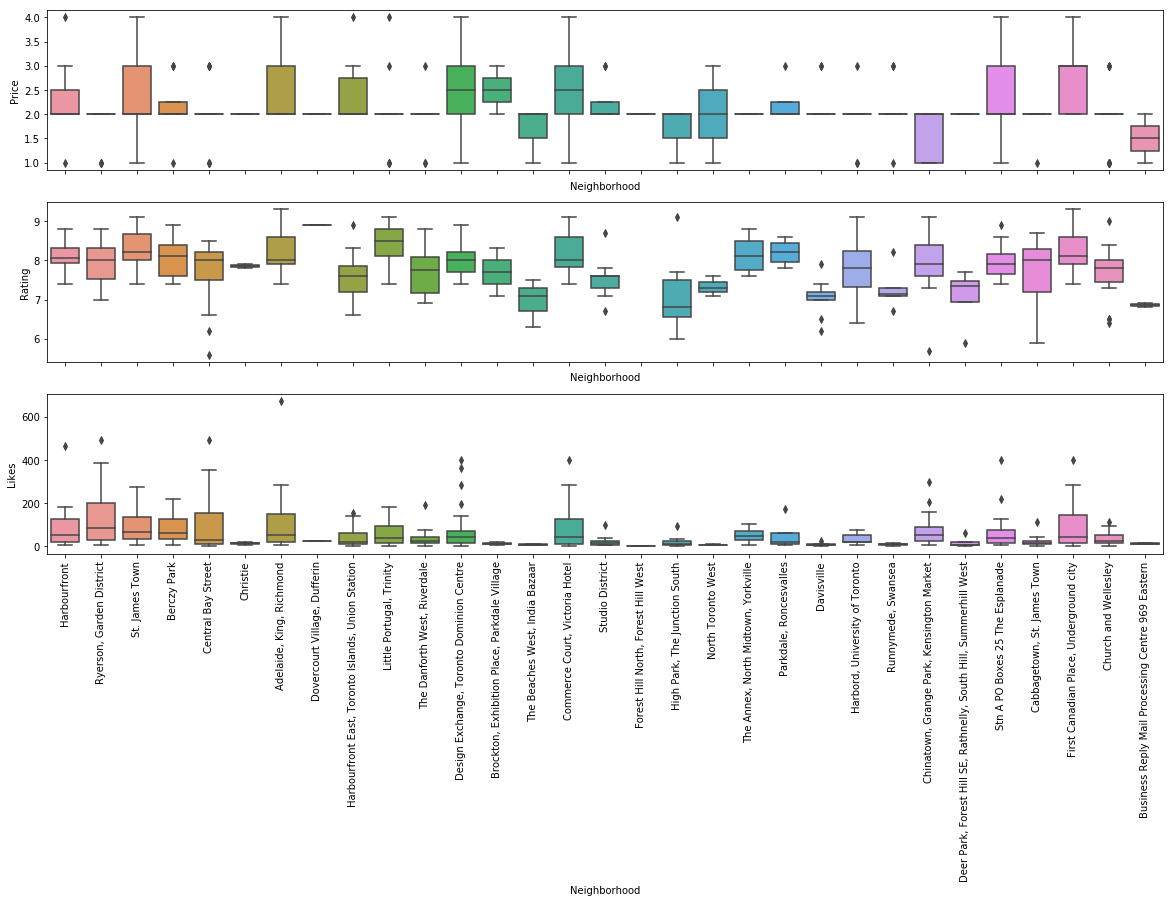

In [61]:
# Boxplot: Price vs Neighborhood, Rating vs Neighborhood, Like vs Neighborhood
fig = plt.figure(figsize=(20,10))

plt.subplot(3, 1, 1)
ax1=sns.boxplot(x='Neighborhood', y='Price', data=toronto_restaurants)
ax1.axes.get_xaxis().set_ticklabels([])

plt.subplot(3, 1, 2)
ax2=sns.boxplot(x='Neighborhood', y='Rating', data=toronto_restaurants)
ax2.axes.get_xaxis().set_ticklabels([])

plt.subplot(3, 1, 3)
ax3=sns.boxplot(x='Neighborhood', y='Likes', data=toronto_restaurants)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)

plt.show()

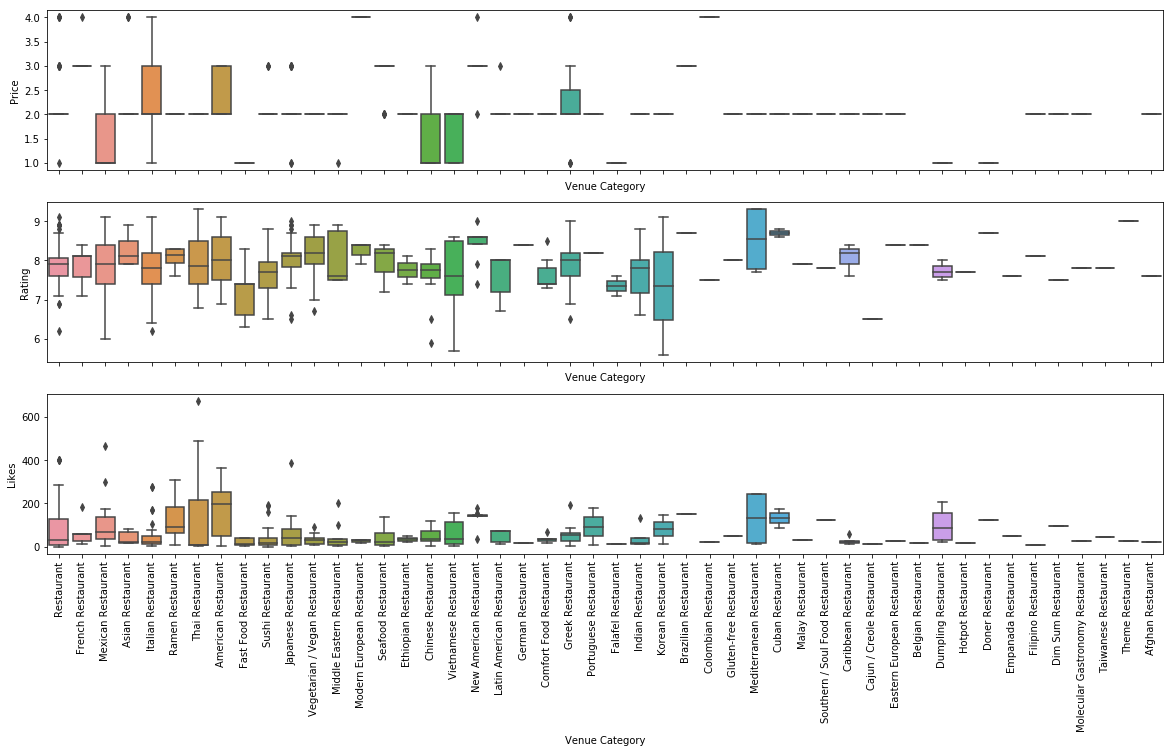

In [62]:
# Boxplot: Price vs Category, Rating vs Category, Like vs Category
fig = plt.figure(figsize=(20,10))

plt.subplot(3, 1, 1)
ax1=sns.boxplot(x='Venue Category', y='Price', data=toronto_restaurants)
ax1.axes.get_xaxis().set_ticklabels([])

plt.subplot(3, 1, 2)
ax2=sns.boxplot(x='Venue Category', y='Rating', data=toronto_restaurants)
ax2.axes.get_xaxis().set_ticklabels([])

plt.subplot(3, 1, 3)
ax3=sns.boxplot(x='Venue Category', y='Likes', data=toronto_restaurants)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)

plt.show()

In [63]:
# Group rows by 'Neighborhood' and 'Venue Category', and get average price, rating, and likes
toronto_restaurants_grouped2=toronto_restaurants.drop(['Venue Latitude', 'Venue Longitude'], axis=1).groupby(['Neighborhood', 'Venue Category']).mean().reset_index()

print('The size of toronto_restaurants_grouped2:', toronto_restaurants_grouped2.shape)
toronto_restaurants_grouped2.head()

The size of toronto_restaurants_grouped2: (260, 7)


,Neighborhood,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Price,Rating,Likes
0,"Adelaide, King, Richmond",American Restaurant,43.650571,-79.384568,2.500000,8.850000,224.000000
1,"Adelaide, King, Richmond",Asian Restaurant,43.650571,-79.384568,2.666667,8.166667,35.666667
2,"Adelaide, King, Richmond",Brazilian Restaurant,43.650571,-79.384568,3.000000,8.700000,149.000000
3,"Adelaide, King, Richmond",Colombian Restaurant,43.650571,-79.384568,4.000000,7.500000,23.000000
4,"Adelaide, King, Richmond",Gluten-free Restaurant,43.650571,-79.384568,2.000000,8.000000,47.000000


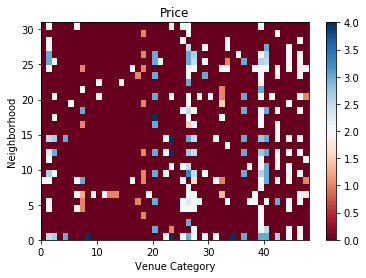

In [64]:
grouped_pivot=toronto_restaurants_grouped2[['Neighborhood', 'Venue Category', 'Price']].pivot(index='Neighborhood', columns='Venue Category')
grouped_pivot
grouped_pivot=grouped_pivot.fillna(0)
plt.pcolor(grouped_pivot, cmap='RdBu')
plt.colorbar()
plt.xlabel('Venue Category')
plt.ylabel('Neighborhood')
plt.title('Price')
plt.show()

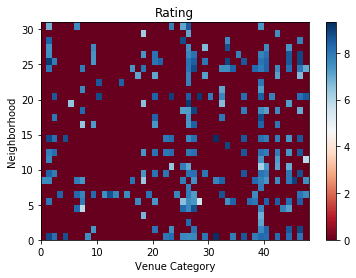

In [65]:
grouped_pivot2=toronto_restaurants_grouped2[['Neighborhood', 'Venue Category', 'Rating']].pivot(index='Neighborhood', columns='Venue Category')
grouped_pivot2=grouped_pivot2.fillna(0)
plt.pcolor(grouped_pivot2, cmap='RdBu')
plt.colorbar()
plt.xlabel('Venue Category')
plt.ylabel('Neighborhood')
plt.title('Rating')
plt.show()

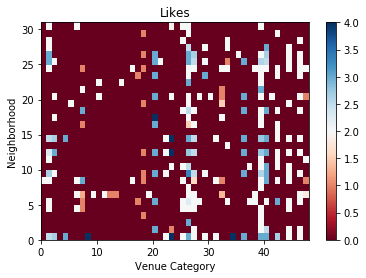

In [66]:
grouped_pivot3=toronto_restaurants_grouped2[['Neighborhood', 'Venue Category', 'Likes']].pivot(index='Neighborhood', columns='Venue Category')
grouped_pivot3=grouped_pivot3.fillna(0)
plt.pcolor(grouped_pivot, cmap='RdBu')
plt.colorbar()
plt.xlabel('Venue Category')
plt.ylabel('Neighborhood')
plt.title('Likes')
plt.show()

In [67]:
# Number of restaurants in each price tier
# Using value_counts will not be able to get the null values
for i in range(4):
    print('The total number of restaurants in price tier ', i+1, ':', (toronto_restaurants['Price']==i+1).sum())
print('The total number of restaurants do not have price information:', (toronto_restaurants['Price'].isnull()).sum())    

The total number of restaurants in price tier  1 : 43
The total number of restaurants in price tier  2 : 244
The total number of restaurants in price tier  3 : 76
The total number of restaurants in price tier  4 : 19
The total number of restaurants do not have price information: 16


## 2.4 Italian Restaurants

In [68]:
# Create dataframe toronto_italian with only venues categorized as italian restaurant
toronto_italian = toronto_restaurants.loc[(toronto_restaurants['Venue Category'].str.contains('italian restaurant', case=False))].reset_index(drop=True)
print('The total number of italian restaurants:', len(toronto_italian))
toronto_italian.head()

The total number of italian restaurants: 44


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Price,Rating,Likes
0,Harbourfront,43.654260,-79.360636,Archeo,4ac3e6cef964a520629d20e3,43.650667,-79.359431,Italian Restaurant,2.0,7.4,20.0
1,"Ryerson, Garden District",43.657162,-79.378937,Trattoria Mercatto,4d306dd82748b60c62b6dba0,43.654453,-79.380974,Italian Restaurant,2.0,8.0,106.0
2,"Ryerson, Garden District",43.657162,-79.378937,Scaddabush Italian Kitchen & Bar,52f6816f11d24a43115dc834,43.658920,-79.382891,Italian Restaurant,2.0,8.1,171.0
3,St. James Town,43.651494,-79.375418,Terroni,4b49183ff964a520a46526e3,43.650927,-79.375602,Italian Restaurant,3.0,8.7,275.0
4,St. James Town,43.651494,-79.375418,La Bettola Di Terroni,4c251062db519521621d2c3a,43.651993,-79.378056,Italian Restaurant,3.0,8.0,69.0


In [69]:
# Total number of neighborhoods that have italian restaurants
len(toronto_italian['Neighborhood'].unique())

23

In [70]:
# Group by Neighborhood
toronto_italian_grouped=toronto_italian[['Neighborhood', 'Price', 'Rating', 'Likes']].groupby('Neighborhood').mean().reset_index()[['Neighborhood', 'Price', 'Likes', 'Rating']]
toronto_italian_grouped.columns=['Neighborhood', 'Ave Price', 'Ave Likes', 'Ave Rating']
toronto_italian_grouped['Min Rating']=toronto_italian[['Neighborhood','Rating']].groupby('Neighborhood').min().reset_index()['Rating']
toronto_italian_grouped['Max Rating']=toronto_italian[['Neighborhood','Rating']].groupby('Neighborhood').max().reset_index()['Rating']
print('The size of toronto_italian_grouped:', toronto_italian_grouped.shape)
toronto_italian_grouped.head()

The size of toronto_italian_grouped: (23, 6)


,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating
0,"Adelaide, King, Richmond",3.00,45.0,7.60,7.6,7.6
1,"Brockton, Exhibition Place, Parkdale Village",3.00,21.0,8.30,8.3,8.3
2,"Cabbagetown, St. James Town",2.00,24.5,7.65,7.1,8.2
3,Central Bay Street,2.25,64.0,7.55,6.2,8.2
4,"Chinatown, Grange Park, Kensington Market",2.00,71.0,7.90,7.9,7.9


In [71]:
# Sort by Rating in ascending order
toronto_italian_grouped.sort_values(by='Ave Rating')

,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating
21,"The Beaches West, India Bazaar",2.000000,10.000000,7.100000,7.1,7.1
7,Davisville,2.500000,8.500000,7.100000,7.1,7.1
12,"Harbourfront East, Toronto Islands, Union Station",2.500000,26.750000,7.250000,6.6,7.9
10,"Harbord, University of Toronto",1.500000,38.000000,7.350000,6.4,8.3
11,Harbourfront,2.000000,20.000000,7.400000,7.4,7.4
20,Studio District,2.500000,23.000000,7.450000,7.1,7.8
3,Central Bay Street,2.250000,64.000000,7.550000,6.2,8.2
9,"First Canadian Place, Underground city",3.000000,45.000000,7.600000,7.6,7.6
0,"Adelaide, King, Richmond",3.000000,45.000000,7.600000,7.6,7.6
2,"Cabbagetown, St. James Town",2.000000,24.500000,7.650000,7.1,8.2


In [72]:
# Number of italian restaurants in each price tier
for i in range(4):
    print('The total number of italian restaurants in price tier ', i+1, ':', (toronto_italian['Price']==i+1).sum())
print('The total number of italian restaurants do not have price information:', (toronto_italian['Price'].isnull()).sum())    

The total number of italian restaurants in price tier  1 : 1
The total number of italian restaurants in price tier  2 : 26
The total number of italian restaurants in price tier  3 : 13
The total number of italian restaurants in price tier  4 : 4
The total number of italian restaurants do not have price information: 0


In [73]:
# Since Price Tier 2 is the most popular one (both toronto_restaurants and toronto_italian), we will take a more close look at the italian restaurants in this price tier. 
toronto_italian_p2 = toronto_italian.loc[toronto_italian['Price']==2].reset_index(drop=True)
print('The number of neighhourhoods have price tier 2 italian restaurants:', len(toronto_italian_p2['Neighborhood'].unique()))

The number of neighhourhoods have price tier 2 italian restaurants: 17


In [74]:
# Group by Neighborhood
toronto_italian_p2_grouped=toronto_italian_p2[['Neighborhood', 'Price', 'Rating', 'Likes']].groupby('Neighborhood').mean().reset_index()[['Neighborhood', 'Price', 'Likes', 'Rating']]
toronto_italian_p2_grouped.columns=['Neighborhood', 'Ave Price', 'Ave Likes', 'Ave Rating']
toronto_italian_p2_grouped['Min Rating']=toronto_italian_p2[['Neighborhood','Rating']].groupby('Neighborhood').min().reset_index()['Rating']
toronto_italian_p2_grouped['Max Rating']=toronto_italian_p2[['Neighborhood','Rating']].groupby('Neighborhood').max().reset_index()['Rating']
print('The size of toronto_italian_p2_grouped:', toronto_italian_p2_grouped.shape)
toronto_italian_p2_grouped.head()

The size of toronto_italian_p2_grouped: (17, 6)


,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating
0,"Cabbagetown, St. James Town",2.0,24.5,7.650000,7.1,8.2
1,Central Bay Street,2.0,67.0,7.333333,6.2,8.1
2,"Chinatown, Grange Park, Kensington Market",2.0,71.0,7.900000,7.9,7.9
3,Christie,2.0,6.0,7.800000,7.8,7.8
4,Davisville,2.0,10.0,7.100000,7.1,7.1


In [75]:
# Sort by Rating in ascending order
toronto_italian_p2_grouped.sort_values(by='Ave Rating')

,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating
14,Studio District,2.0,37.0,7.100000,7.1,7.1
4,Davisville,2.0,10.0,7.100000,7.1,7.1
15,"The Beaches West, India Bazaar",2.0,10.0,7.100000,7.1,7.1
1,Central Bay Street,2.0,67.0,7.333333,6.2,8.1
13,Stn A PO Boxes 25 The Esplanade,2.0,6.0,7.400000,7.4,7.4
7,Harbourfront,2.0,20.0,7.400000,7.4,7.4
8,"Harbourfront East, Toronto Islands, Union Station",2.0,28.0,7.466667,6.8,7.9
0,"Cabbagetown, St. James Town",2.0,24.5,7.650000,7.1,8.2
11,"Runnymede, Swansea",2.0,9.0,7.750000,7.3,8.2
3,Christie,2.0,6.0,7.800000,7.8,7.8


In [76]:
toronto_italian_p2_grouped['Number of P2 Italian']=toronto_italian_p2[['Neighborhood', 'Venue']].groupby('Neighborhood').count().reset_index()['Venue']
toronto_italian_p2_grouped

,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating,Number of P2 Italian
0,"Cabbagetown, St. James Town",2.0,24.5,7.650000,7.1,8.2,2
1,Central Bay Street,2.0,67.0,7.333333,6.2,8.1,3
2,"Chinatown, Grange Park, Kensington Market",2.0,71.0,7.900000,7.9,7.9,1
3,Christie,2.0,6.0,7.800000,7.8,7.8,1
4,Davisville,2.0,10.0,7.100000,7.1,7.1,1
5,"Design Exchange, Toronto Dominion Centre",2.0,42.0,7.900000,7.7,8.1,2
6,"Harbord, University of Toronto",2.0,58.0,8.300000,8.3,8.3,1
7,Harbourfront,2.0,20.0,7.400000,7.4,7.4,1
8,"Harbourfront East, Toronto Islands, Union Station",2.0,28.0,7.466667,6.8,7.9,3
9,"High Park, The Junction South",2.0,35.0,9.100000,9.1,9.1,1


In [77]:
toronto_grouped_sum[['Neighborhood', 'Total Venues','Total Restaurants', 'Percent Restaurant', 'Italian Restaurant']]

,Neighborhood,Total Venues,Total Restaurants,Percent Restaurant,Italian Restaurant
0,"Adelaide, King, Richmond",99,29,0.292929,1
1,Berczy Park,56,9,0.160714,0
2,"Brockton, Exhibition Place, Parkdale Village",22,2,0.090909,1
3,Business Reply Mail Processing Centre 969 Eastern,16,2,0.125000,0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",14,0,0.000000,0
5,"Cabbagetown, St. James Town",45,11,0.244444,2
6,Central Bay Street,84,22,0.261905,4
7,"Chinatown, Grange Park, Kensington Market",90,34,0.377778,1
8,Christie,17,2,0.117647,1
9,Church and Wellesley,83,27,0.325301,0


In [78]:
toronto_italian_p2_grouped=pd.merge(toronto_italian_p2_grouped, toronto_grouped_sum[['Neighborhood', 'Total Venues','Total Restaurants', 'Percent Restaurant', 'Italian Restaurant']], how='inner', left_on='Neighborhood', right_on='Neighborhood')
toronto_italian_p2_grouped

,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating,Number of P2 Italian,Total Venues,Total Restaurants,Percent Restaurant,Italian Restaurant
0,"Cabbagetown, St. James Town",2.0,24.5,7.650000,7.1,8.2,2,45,11,0.244444,2
1,Central Bay Street,2.0,67.0,7.333333,6.2,8.1,3,84,22,0.261905,4
2,"Chinatown, Grange Park, Kensington Market",2.0,71.0,7.900000,7.9,7.9,1,90,34,0.377778,1
3,Christie,2.0,6.0,7.800000,7.8,7.8,1,17,2,0.117647,1
4,Davisville,2.0,10.0,7.100000,7.1,7.1,1,34,10,0.294118,2
5,"Design Exchange, Toronto Dominion Centre",2.0,42.0,7.900000,7.7,8.1,2,100,26,0.260000,4
6,"Harbord, University of Toronto",2.0,58.0,8.300000,8.3,8.3,1,37,10,0.270270,2
7,Harbourfront,2.0,20.0,7.400000,7.4,7.4,1,47,7,0.148936,1
8,"Harbourfront East, Toronto Islands, Union Station",2.0,28.0,7.466667,6.8,7.9,3,99,14,0.141414,4
9,"High Park, The Junction South",2.0,35.0,9.100000,9.1,9.1,1,23,7,0.304348,1


In [79]:
toronto_italian_p2_grouped.sort_values(by='Ave Rating')

,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating,Number of P2 Italian,Total Venues,Total Restaurants,Percent Restaurant,Italian Restaurant
14,Studio District,2.0,37.0,7.100000,7.1,7.1,1,40,9,0.225000,2
4,Davisville,2.0,10.0,7.100000,7.1,7.1,1,34,10,0.294118,2
15,"The Beaches West, India Bazaar",2.0,10.0,7.100000,7.1,7.1,1,22,3,0.136364,1
1,Central Bay Street,2.0,67.0,7.333333,6.2,8.1,3,84,22,0.261905,4
13,Stn A PO Boxes 25 The Esplanade,2.0,6.0,7.400000,7.4,7.4,1,97,19,0.195876,2
7,Harbourfront,2.0,20.0,7.400000,7.4,7.4,1,47,7,0.148936,1
8,"Harbourfront East, Toronto Islands, Union Station",2.0,28.0,7.466667,6.8,7.9,3,99,14,0.141414,4
0,"Cabbagetown, St. James Town",2.0,24.5,7.650000,7.1,8.2,2,45,11,0.244444,2
11,"Runnymede, Swansea",2.0,9.0,7.750000,7.3,8.2,2,33,9,0.272727,2
3,Christie,2.0,6.0,7.800000,7.8,7.8,1,17,2,0.117647,1


In [80]:
toronto_italian_p2_grouped['Percent P2 Italian Restaurant']=toronto_italian_p2_grouped['Number of P2 Italian']/toronto_italian_p2_grouped['Total Venues']
toronto_italian_p2_grouped

,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating,Number of P2 Italian,Total Venues,Total Restaurants,Percent Restaurant,Italian Restaurant,Percent P2 Italian Restaurant
0,"Cabbagetown, St. James Town",2.0,24.5,7.650000,7.1,8.2,2,45,11,0.244444,2,0.044444
1,Central Bay Street,2.0,67.0,7.333333,6.2,8.1,3,84,22,0.261905,4,0.035714
2,"Chinatown, Grange Park, Kensington Market",2.0,71.0,7.900000,7.9,7.9,1,90,34,0.377778,1,0.011111
3,Christie,2.0,6.0,7.800000,7.8,7.8,1,17,2,0.117647,1,0.058824
4,Davisville,2.0,10.0,7.100000,7.1,7.1,1,34,10,0.294118,2,0.029412
5,"Design Exchange, Toronto Dominion Centre",2.0,42.0,7.900000,7.7,8.1,2,100,26,0.260000,4,0.020000
6,"Harbord, University of Toronto",2.0,58.0,8.300000,8.3,8.3,1,37,10,0.270270,2,0.027027
7,Harbourfront,2.0,20.0,7.400000,7.4,7.4,1,47,7,0.148936,1,0.021277
8,"Harbourfront East, Toronto Islands, Union Station",2.0,28.0,7.466667,6.8,7.9,3,99,14,0.141414,4,0.030303
9,"High Park, The Junction South",2.0,35.0,9.100000,9.1,9.1,1,23,7,0.304348,1,0.043478


In [81]:
toronto_italian_p2_grouped.sort_values(by='Ave Rating')

,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating,Number of P2 Italian,Total Venues,Total Restaurants,Percent Restaurant,Italian Restaurant,Percent P2 Italian Restaurant
14,Studio District,2.0,37.0,7.100000,7.1,7.1,1,40,9,0.225000,2,0.025000
4,Davisville,2.0,10.0,7.100000,7.1,7.1,1,34,10,0.294118,2,0.029412
15,"The Beaches West, India Bazaar",2.0,10.0,7.100000,7.1,7.1,1,22,3,0.136364,1,0.045455
1,Central Bay Street,2.0,67.0,7.333333,6.2,8.1,3,84,22,0.261905,4,0.035714
13,Stn A PO Boxes 25 The Esplanade,2.0,6.0,7.400000,7.4,7.4,1,97,19,0.195876,2,0.010309
7,Harbourfront,2.0,20.0,7.400000,7.4,7.4,1,47,7,0.148936,1,0.021277
8,"Harbourfront East, Toronto Islands, Union Station",2.0,28.0,7.466667,6.8,7.9,3,99,14,0.141414,4,0.030303
0,"Cabbagetown, St. James Town",2.0,24.5,7.650000,7.1,8.2,2,45,11,0.244444,2,0.044444
11,"Runnymede, Swansea",2.0,9.0,7.750000,7.3,8.2,2,33,9,0.272727,2,0.060606
3,Christie,2.0,6.0,7.800000,7.8,7.8,1,17,2,0.117647,1,0.058824


In [82]:
toronto_italian_p2_grouped.sort_values(by='Percent P2 Italian Restaurant')

,Neighborhood,Ave Price,Ave Likes,Ave Rating,Min Rating,Max Rating,Number of P2 Italian,Total Venues,Total Restaurants,Percent Restaurant,Italian Restaurant,Percent P2 Italian Restaurant
13,Stn A PO Boxes 25 The Esplanade,2.0,6.0,7.400000,7.4,7.4,1,97,19,0.195876,2,0.010309
2,"Chinatown, Grange Park, Kensington Market",2.0,71.0,7.900000,7.9,7.9,1,90,34,0.377778,1,0.011111
10,"Little Portugal, Trinity",2.0,20.0,8.500000,8.5,8.5,1,55,20,0.363636,1,0.018182
5,"Design Exchange, Toronto Dominion Centre",2.0,42.0,7.900000,7.7,8.1,2,100,26,0.260000,4,0.020000
12,"Ryerson, Garden District",2.0,138.5,8.050000,8.0,8.1,2,100,22,0.220000,2,0.020000
7,Harbourfront,2.0,20.0,7.400000,7.4,7.4,1,47,7,0.148936,1,0.021277
14,Studio District,2.0,37.0,7.100000,7.1,7.1,1,40,9,0.225000,2,0.025000
6,"Harbord, University of Toronto",2.0,58.0,8.300000,8.3,8.3,1,37,10,0.270270,2,0.027027
4,Davisville,2.0,10.0,7.100000,7.1,7.1,1,34,10,0.294118,2,0.029412
8,"Harbourfront East, Toronto Islands, Union Station",2.0,28.0,7.466667,6.8,7.9,3,99,14,0.141414,4,0.030303
